In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt


config = {}
config['layer_specs'] = [784, 50, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
config['activation'] = 'sigmoid' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
config['batch_size'] = 1000  # Number of training samples per batch to be passed to network
config['epochs'] = 50  # Number of epochs to train the model
config['early_stop'] = True  # Implement early stopping or not
config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
config['L2_penalty'] = 0  # Regularization constant
config['momentum'] = False  # Denotes if momentum is to be applied or not
config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
config['learning_rate'] = 0.0001 # Learning rate of gradient descent algorithm

def softmax(x):
    """
    Write the code for softmax activation function that takes in a numpy array and returns a numpy array.
    """
    output = np.array([np.exp(i)/np.sum(np.exp(i))for i in x])
    return output


def load_data(fname):
    """
    Write code to read the data and return it as 2 numpy arrays.
    Make sure to convert labels to one hot encoded format.
    """
    images = []
    labels = []
    data = pickle.load(open(fname, 'rb'), encoding='latin1')
    for d in data:
        images += [d[:-1]]
        labels += [[int(i == d[-1]) for i in range(10)]]
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [2]:
class Activation:
    def __init__(self, activation_type = "sigmoid"):
        self.activation_type = activation_type
        self.x = None # Save the input 'x' for sigmoid or tanh or ReLU to this variable since it will be used later for computing gradients.
  
    def forward_pass(self, a):
        if self.activation_type == "sigmoid":
            return self.sigmoid(a)
    
        elif self.activation_type == "tanh":
            return self.tanh(a)
    
        elif self.activation_type == "ReLU":
            return self.ReLU(a)
  
    def backward_pass(self, delta):
        if self.activation_type == "sigmoid":
            grad = self.grad_sigmoid()
    
        elif self.activation_type == "tanh":
            grad = self.grad_tanh()
    
        elif self.activation_type == "ReLU":
            grad = self.grad_ReLU()
    
        return grad * delta
          
    def sigmoid(self, x):
        """
        Write the code for sigmoid activation function that takes in a numpy array and returns a numpy array.
        """
        self.x = x
        output = 1/(1+np.exp(-x))
        return output
    
    def tanh(self, x):
        """
        Write the code for tanh activation function that takes in a numpy array and returns a numpy array.
        """
        self.x = x
        output = np.tanh(x)
        return output

    def ReLU(self, x):
        """
        Write the code for ReLU activation function that takes in a numpy array and returns a numpy array.
        """
        self.x = x
        output = np.maximum(0,x)
        return output

    def grad_sigmoid(self):
        """
        Write the code for gradient through sigmoid activation function that takes in a numpy array and returns a numpy array.
        """
        grad = np.exp(-self.x)/np.power(1+np.exp(-self.x),2) 
        return grad
    
    def grad_tanh(self):
        """
        Write the code for gradient through tanh activation function that takes in a numpy array and returns a numpy array.
        """
        grad = 1-np.power(np.tanh(self.x), 2)
        return grad

    def grad_ReLU(self):
        """
        Write the code for gradient through ReLU activation function that takes in a numpy array and returns a numpy array.
        """
        grad = np.copy(self.x)
        grad[grad <= 0] = 0
        grad[grad > 0] = 1
        return grad

In [3]:
class Layer():
    def __init__(self, in_units, out_units):
        np.random.seed(42)
        self.w = np.random.randn(in_units, out_units)  # Weight matrix
        self.delta_w = np.zeros((in_units, out_units))
        self.b = np.zeros((1, out_units)).astype(np.float32)  # Bias
        self.delta_b = np.zeros((1, out_units)).astype(np.float32) 
        self.x = None  # Save the input to forward_pass in this
        self.a = None  # Save the output of forward pass in this (without activation)
        self.d_x = None  # Save the gradient w.r.t x in this
        self.d_w = None  # Save the gradient w.r.t w in this
        self.d_b = None  # Save the gradient w.r.t b in this

    def forward_pass(self, x):
        """
        Write the code for forward pass through a layer. Do not apply activation function here.
        """
        self.x = x
        self.a = self.x @ self.w + np.repeat(self.b, len(x), axis = 0)
        return self.a
  
    def backward_pass(self, delta):
        """
        Write the code for backward pass. This takes in gradient from its next layer as input,
        computes gradient for its weights and the delta to pass to its previous layers.
        """
        self.d_x =  delta @ self.w.T
        self.d_w =  self.x.T @ delta 
        self.d_b =  np.sum(delta,axis = 0 )
        return self.d_x

In [4]:
def plot_loss(epoch,t_err,h_err):
    plt.plot(epoch, t_err)
    plt.plot(epoch, h_err)
    plt.legend(['training loss', 'validation loss'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('epoch number')
    plt.ylabel('Cross Entropy Loss')
    plt.show()

def plot_acc(epoch, t_acc, h_acc):
    plt.plot(epoch, t_acc)
    plt.plot(epoch, h_acc)
    plt.legend(['training accuracy', 'validation accuracy'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('epoch number')
    plt.ylabel('Accuracy in Percentage(%)')
    plt.show()

In [5]:
class Neuralnetwork():
    def __init__(self, config):
        self.layers = []
        self.x = None  # Save the input to forward_pass in this
        self.y = None  # Save the output vector of model in this
        self.targets = None  # Save the targets in forward_pass in this variable
        for i in range(len(config['layer_specs']) - 1):
            self.layers.append( Layer(config['layer_specs'][i], config['layer_specs'][i+1]) )
            if i < len(config['layer_specs']) - 2:
                self.layers.append(Activation(config['activation']))  
    
    def forward_pass(self, x, targets=None):
        """
        Write the code for forward pass through all layers of the model and return loss and predictions.
        If targets == None, loss should be None. If not, then return the loss computed.
        """
        self.x = x
        self.targets = targets
        for l in self.layers:
            x = l.forward_pass(x)
            
        self.y = softmax(x)
        
        loss = None
        accuracy = None
        if targets is not None:
            num = 0
            loss = self.loss_func(self.y, targets)
            for (y,t) in zip(self.y, targets):
                num = num + 1 if np.argmax(y) == np.argmax(t) else num
            accuracy = 100*num/len(targets)
        return loss, accuracy, self.y

    def loss_func(self, logits, targets):
        '''
        find cross entropy loss between logits and targets
        '''
        output = -np.sum(targets * np.log(logits))/len(logits)
        return output
    
    def backward_pass(self):
        '''
        implement the backward pass for the whole network. 
        hint - use previously built functions.
        '''
        delta = (self.targets - self.y)
        for l in self.layers[::-1]:
            delta = l.backward_pass(delta)
            
        return delta

def trainer(model, X_train, y_train, X_valid, y_valid, config):
    """
    Write the code to train the network. Use values from config to set parameters
    such as L2 penalty, number of epochs, momentum, etc.
    """
    batch_size = config['batch_size']
    L2_penalty = config['L2_penalty']
    epochs = config['epochs']
    early_stop_epoch = config['early_stop_epoch']
    gamma = config['momentum_gamma'] 
    learning_rate = config['learning_rate']
    
    train_e = []
    valid_e = []
    train_a = []
    valid_a = []
    
    epoch_list = []
    error = np.inf
    latest_valid_error = np.inf
    best_w = None
    best_b = None
    num = 0
    for e in range(epochs):
        batch_e = []
        batch_a = []
        for i in range(int(len(X_train)/batch_size)):
            x_batch = X_train[i*batch_size:(i+1)*batch_size]
            targets = y_train[i*batch_size:(i+1)*batch_size]
            train_error, train_acc, train_pred = model.forward_pass(x_batch, targets)
            batch_e += [train_error]
            batch_a += [train_acc]
            
            model.backward_pass()
            for l in model.layers:
                if isinstance(l,Layer):
                    l.delta_w = learning_rate*(l.delta_w*gamma*int(config['momentum']) + l.d_w) - L2_penalty*l.w
#                     l.delta_w = l.delta_w*gamma*int(config['momentum']) + learning_rate*l.d_w - L2_penalty*l.w
                    l.w += l.delta_w
                    l.delta_b = learning_rate*(l.delta_b*gamma*int(config['momentum']) + l.d_b) - L2_penalty*l.b
                    l.b += l.delta_b
        
        epoch_list += [e+1]
        train_e += [np.mean(batch_e)]
        train_a += [np.mean(batch_a)]
        
#         print(l.b)
        valid_error, valid_acc, valid_pred = model.forward_pass(X_valid, y_valid)
        valid_e += [valid_error]
        valid_a += [valid_acc]
        
        if valid_error < error:
            error = valid_error
            best_w = [l.w for l in model.layers if isinstance(l, Layer)]
            best_b = [l.b for l in model.layers if isinstance(l, Layer)]
            
        if (config['early_stop']):
            if valid_error >= latest_valid_error:
                num += 1
            else:
                num = 0
                
            if num == early_stop_epoch:
                break
        latest_valid_error = valid_error
        
    index = 0    
    for l in model.layers:
        if isinstance(l,Layer):
            l.w = best_w[index]
            l.b = best_b[index]
            index += 1
    
    plot_loss(epoch_list, train_e, valid_e)
    plot_acc(epoch_list, train_a, valid_a)
    
    return model
                                                  

def test(model, X_test, y_test, config):
    """
    Write code to run the model on the data passed as input and return accuracy.
    """
    error, accuracy, pred = model.forward_pass(X_test, y_test)
    return accuracy

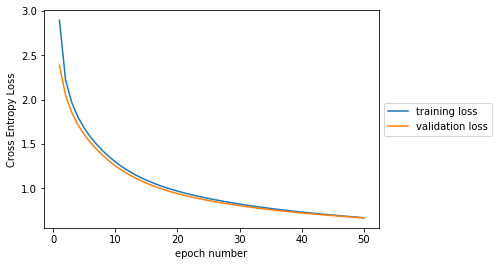

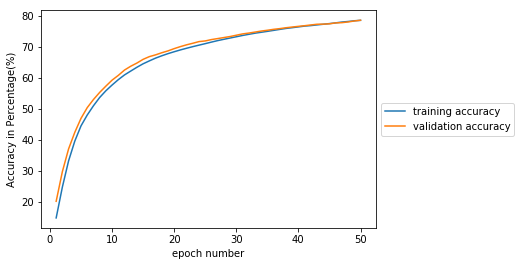

78.73


In [6]:
if __name__ == "__main__":
    train_data_fname = 'MNIST_train.pkl'
    valid_data_fname = 'MNIST_valid.pkl'
    test_data_fname = 'MNIST_test.pkl'
  
    ### Train the network ###
    model = Neuralnetwork(config)
    X_train, y_train = load_data(train_data_fname)
    X_valid, y_valid = load_data(valid_data_fname)
    X_test, y_test = load_data(test_data_fname)

    trainer(model, X_train, y_train, X_valid, y_valid, config)
    test_acc = test(model, X_test, y_test, config)
    print(test_acc)
    

In [ ]:
def learningrate(lr):
    train_data_fname = 'MNIST_train.pkl'
    valid_data_fname = 'MNIST_valid.pkl'
    test_data_fname = 'MNIST_test.pkl'
  
    ### Train the network ###
    
    config = {}
    config['layer_specs'] = [784, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
    config['activation'] = 'tanh' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
    config['batch_size'] = 1000  # Number of training samples per batch to be passed to network
    config['epochs'] = 50  # Number of epochs to train the model
    config['early_stop'] = True  # Implement early stopping or not
    config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
    config['L2_penalty'] = 0 # Regularization constant
    config['momentum'] = True  # Denotes if momentum is to be applied or not
    config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
    config['learning_rate'] = lr # Learning rate of gradient descent algorithm
    model = Neuralnetwork(config)
    X_train, y_train = load_data(train_data_fname)
    X_valid, y_valid = load_data(valid_data_fname)
    X_test, y_test = load_data(test_data_fname)
    
    trainer(model, X_train, y_train, X_valid, y_valid, config)
    test_acc = test(model, X_test, y_test, config)
    print(test_acc)

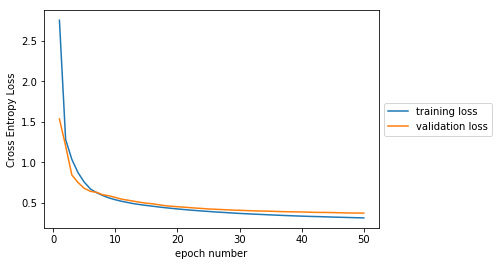

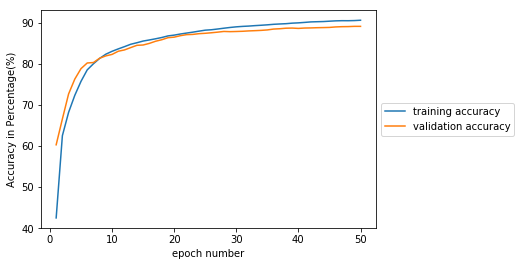

89.2


In [8]:
learningrate(0.001)

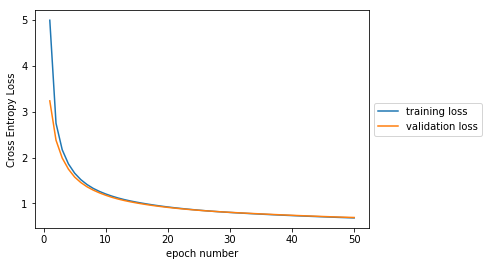

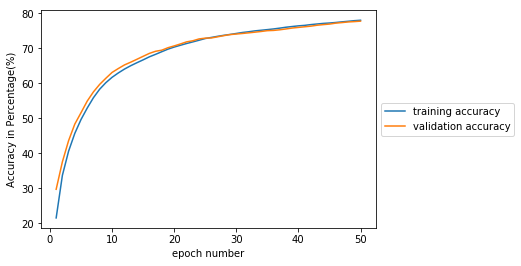

78.06


In [9]:
learningrate(0.0001)

In [10]:
def regularization(L2_penalty):
    train_data_fname = 'MNIST_train.pkl'
    valid_data_fname = 'MNIST_valid.pkl'
    test_data_fname = 'MNIST_test.pkl'
  
    ### Train the network ###
    
    config = {}
    config['layer_specs'] = [784, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
    config['activation'] = 'tanh' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
    config['batch_size'] = 1000  # Number of training samples per batch to be passed to network
    config['epochs'] = 55  # Number of epochs to train the model
    config['early_stop'] = True  # Implement early stopping or not
    config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
    config['L2_penalty'] = L2_penalty # Regularization constant
    config['momentum'] = True  # Denotes if momentum is to be applied or not
    config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
    config['learning_rate'] = 0.0001 # Learning rate of gradient descent algorithm
    model = Neuralnetwork(config)
    X_train, y_train = load_data(train_data_fname)
    X_valid, y_valid = load_data(valid_data_fname)
    X_test, y_test = load_data(test_data_fname)

    trainer(model, X_train, y_train, X_valid, y_valid, config)
    test_acc = test(model, X_test, y_test, config)
    print(test_acc)

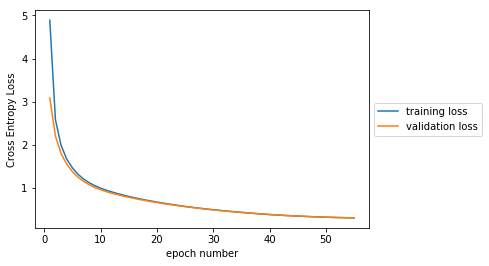

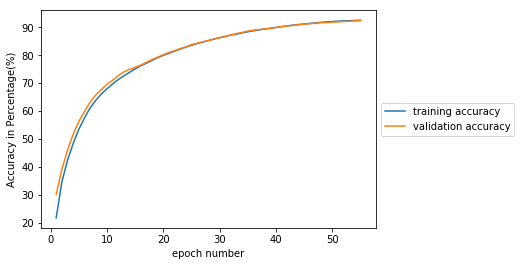

93.01


In [11]:
regularization(0.001)

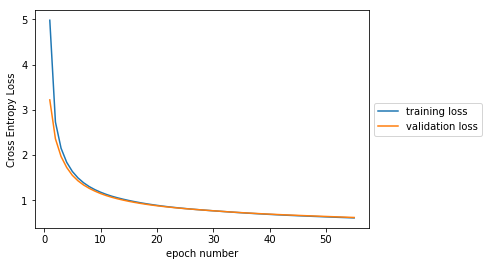

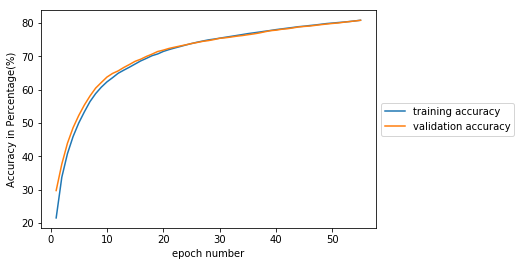

80.46


In [12]:
regularization(0.0001)

In [7]:
def activation_func(active,lr=0.001):
    train_data_fname = 'MNIST_train.pkl'
    valid_data_fname = 'MNIST_valid.pkl'
    test_data_fname = 'MNIST_test.pkl'
  
    ### Train the network ###
    
    config = {}
    config['layer_specs'] = [784, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
    config['activation'] = active # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
    config['batch_size'] = 1000  # Number of training samples per batch to be passed to network
    config['epochs'] = 50  # Number of epochs to train the model
    config['early_stop'] = True  # Implement early stopping or not
    config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
    config['L2_penalty'] = 0 # Regularization constant
    config['momentum'] = True  # Denotes if momentum is to be applied or not
    config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
    config['learning_rate'] = lr # Learning rate of gradient descent algorithm
    model = Neuralnetwork(config)
    X_train, y_train = load_data(train_data_fname)
    X_valid, y_valid = load_data(valid_data_fname)
    X_test, y_test = load_data(test_data_fname)
    
    if (config['activation'] == 'ReLU'):
        for l in model.layers:
            if isinstance(l,Layer):
                factor = np.sum(l.w.shape)
                l.w = l.w/factor
        config['learning_rate'] = config['learning_rate']/10
    trainer(model, X_train, y_train, X_valid, y_valid, config)
    test_acc = test(model, X_test, y_test, config)
    print(test_acc)

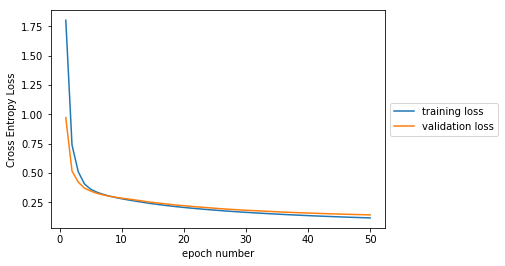

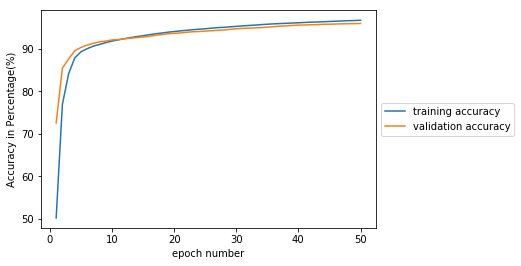

96.22


In [8]:
activation_func('ReLU')

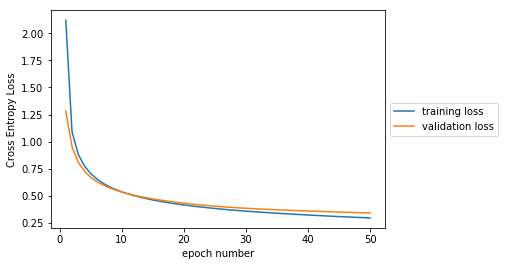

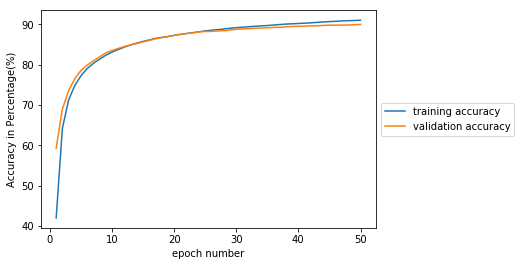

90.36


In [15]:
activation_func('sigmoid')

In [16]:
def topology(layer_specs):
    train_data_fname = 'MNIST_train.pkl'
    valid_data_fname = 'MNIST_valid.pkl'
    test_data_fname = 'MNIST_test.pkl'
  
    ### Train the network ###
    
    config = {}
    config['layer_specs'] = layer_specs  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
    config['activation'] = 'tanh' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
    config['batch_size'] = 1000  # Number of training samples per batch to be passed to network
    config['epochs'] = 50  # Number of epochs to train the model
    config['early_stop'] = True  # Implement early stopping or not
    config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
    config['L2_penalty'] = 0 # Regularization constant
    config['momentum'] = True  # Denotes if momentum is to be applied or not
    config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
    config['learning_rate'] = 0.001 # Learning rate of gradient descent algorithm
    model = Neuralnetwork(config)
    X_train, y_train = load_data(train_data_fname)
    X_valid, y_valid = load_data(valid_data_fname)
    X_test, y_test = load_data(test_data_fname)

    trainer(model, X_train, y_train, X_valid, y_valid, config)
    test_acc = test(model, X_test, y_test, config)
    print(test_acc)

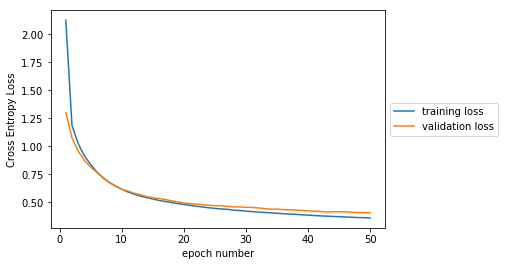

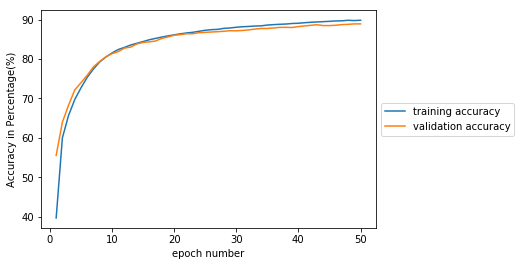

89.27


In [17]:
topology([784, 25, 10])

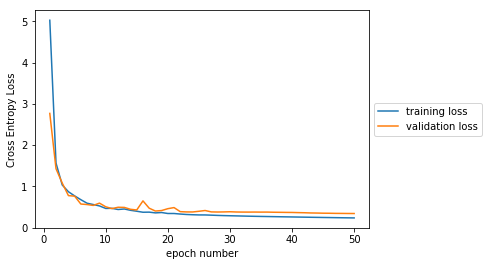

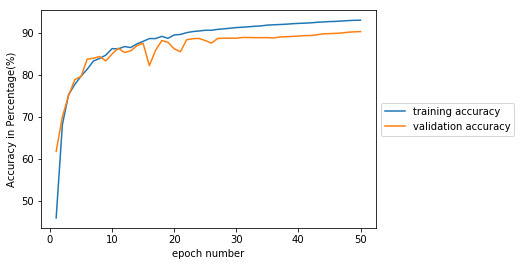

90.46


In [18]:
topology([784, 100, 10])

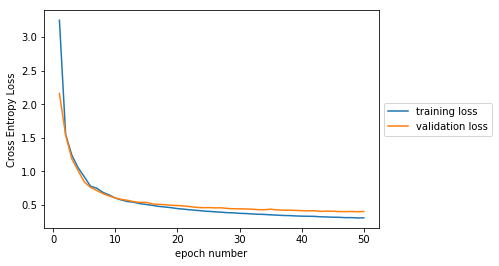

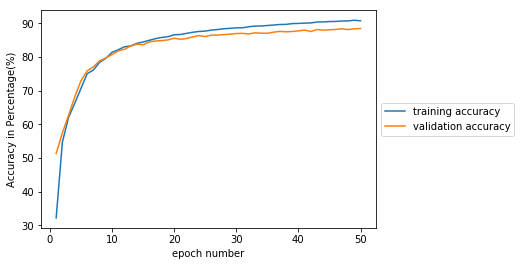

88.75


In [19]:
topology([784, 45, 45, 10])

In [36]:
def numeric_approx(e):
    neural = Neuralnetwork(config)
    x = X_train
    targets = y_train
    dict1 = {0:"input to hidden", -1: "hidden to output"}
   
    # input to hidden, then hidden to output 
    for j in [0,-1]:
        #  choose w1,1 w2,2
        for i in [1,2]:
            l = neural.layers[j]
            w = np.copy(l.w)
            neural.forward_pass(x,targets)
            neural.backward_pass()
            # gradient by backpropagate
            print(dict1[j],"W",str(i)+","+str(i),":")
            d_w = -l.d_w[i][i]/len(x)
            print(d_w)

            l.w[i][i] = w[i][i]+e
            loss_plus = neural.forward_pass(x,targets)[0]

            l.w[i][i] = w[i][i]-e
            loss_minus = neural.forward_pass(x,targets)[0]
            approx = (loss_plus-loss_minus)/(2*e)
            # gradient by numerical approximation
            print(approx)
            diff = np.abs(approx - d_w)
            print(np.format_float_scientific(diff))
            
            
        l = neural.layers[j]
        b = np.copy(l.b)
        neural.forward_pass(x,targets)
        neural.backward_pass()
        # gradient by backpropagate
        print(dict1[j],"B",str(i),":")
        d_b = -l.d_b[i]/len(x)
        print(d_b)

        l.b[0][i] = b[0][i]+e
        loss_plus = neural.forward_pass(x,targets)[0]

        l.b[0][i] = b[0][i]-e
        loss_minus = neural.forward_pass(x,targets)[0]
        approx = (loss_plus-loss_minus)/(2*e)
        # gradient by numerical approximation
        print(approx)
        diff = np.abs(approx - d_b)
        print(np.format_float_scientific(diff))

In [37]:
numeric_approx(0.01)

input to hidden W 1,1 :
0.0012747609874263369
0.001274761493830212
5.064038752135985e-10
input to hidden W 2,2 :
-0.0007886136649042693
-0.0007886140057866697
3.4088240043195217e-10
input to hidden B 2 :
0.0007861338703251932
0.0007861342113280045
3.410028113831273e-10
hidden to output W 1,1 :
0.3005404328615423
0.30054034620183856
8.665970374632792e-08
hidden to output W 2,2 :
-0.006744991367732083
-0.006744985833240236
5.534491847453138e-09
hidden to output B 2 :
-0.0711812453645377
-0.0711808917236656
3.5364087209999173e-07
